In [96]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [97]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head(10)

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
5       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   
6       0  1467811592  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY   
7       0  1467811594  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY   
8       0  1467811795  Mon Apr 06 22:20:05 PDT 2009  NO_QUERY   
9       0  1467812025  Mon Apr 06 22:20:09 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
5         joy_wolf                      @Kwesidei not the whole crew   
6          mybirch                                        Need a hug   
7             coZZ  @LOLTrish hey  long time no see! Yes.. Rains a...  
8  2Hood4Hollywood               @Tatiana_K nope they didn't have it   
9          mimismo                          @twittera que me muera ?

In [98]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [99]:
print('Размер данных', len(df))

Размер данных 1600000


In [100]:
df.shape

(1600000, 6)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [102]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

<h1>Проверка на нулевые данные</h1>

In [103]:
np.sum(df.isnull().any(axis=1))

0

<h1>Длина строк и столбцов датасета</h1>

In [104]:
print('Длина столбцов:  ', len(df.columns))
print('Длина строк:  ', len(df))

Длина столбцов:   6
Длина строк:   1600000


<h1>Проверка уникальных целевых значений</h1>

In [105]:
df['target'].unique()

array([0, 4])

<h1>Kоличество целевых значений</h1>



In [106]:
df['target'].nunique()

2

<h1>Визуализация данных о целевых переменных</h1>

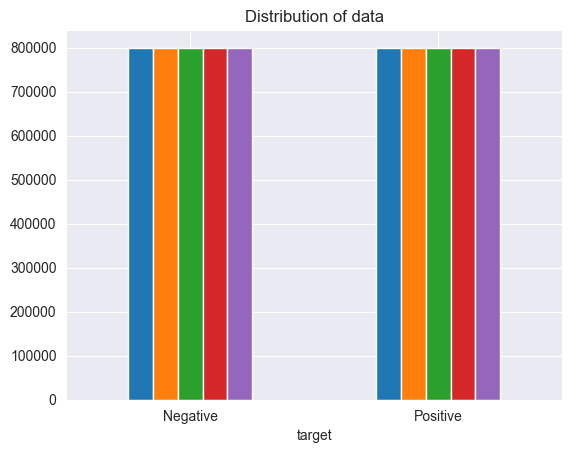

In [107]:
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(df['text']), list(df['target'])



<Axes: xlabel='target', ylabel='count'>

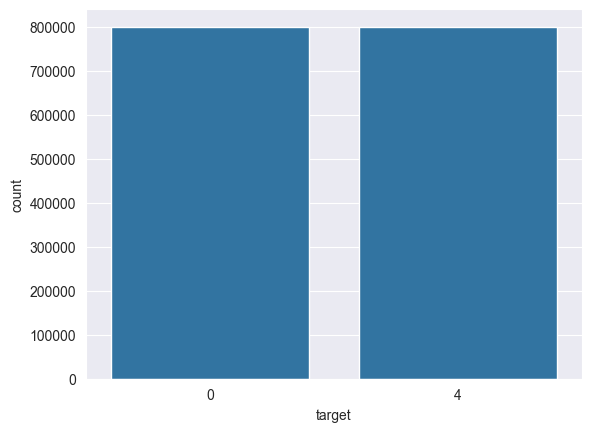

In [108]:
import seaborn as sns
sns.countplot(x='target', data=df)

В данной постановке задачи перед обучением модели мы выполнили различные шаги по предварительной обработке набора данных, которые в основном заключались в удалении стоп-слов, специальных символов, таких как эмодзи, хэштеги и т. д. Затем текстовый документ преобразуется в строчные буквы для лучшего обобщения.

Затем были очищены и удалены знаки препинания, что позволило уменьшить ненужный шум в наборе данных. После этого мы также удалили повторяющиеся символы из слов, а также URL, поскольку они не имеют существенного значения.

Наконец, мы выполнили стемминг (сокращение слов до их производных стеблей) и лемматизацию (сокращение производных слов до их корневой формы, известной как лемма) для достижения лучших результатов.

 <h1>Выбор текста и целевой колонки для дальнейшего анализа</h1>

In [109]:
data=df[['text','target']]

<h1>Заменяем значения, чтобы облегчить понимание. (Присваиваем 1 положительному настроению 4)</h1>

In [110]:
data['target'] = data['target'].replace(4,1)

/var/folders/y8/ndh9qhzj7t98rv05wws177ph0000gn/T/ipykernel_21674/64576989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [111]:
data['target'].unique()

array([0, 1])

<h1>Разделение положительных и отрицательных твитов</h1>

In [112]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]
data_mid = data[data['target'] == 0.5]

<h1>Берем одну четвертую часть данных, чтобы мы легко запустили ее на нашей машине</h1>

In [113]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
data_mid = data_mid.iloc[:int(20000)]

<h1>Комбинируем наши положительные и отрицательные данные</h1>

In [114]:
dataset = pd.concat([data_pos, data_neg, data_mid])

<h1>Меняем текст в нижний регистр</h1>

In [115]:
dataset['text']=dataset['text'].str.lower()

<h1>Определяем множество, содержащее все стоп-слова в английском языке.</h1>

In [116]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

<h1>Очистка и удаление списка стоп-слов из текста твита</h1>

In [117]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

<h1>Удаление знаков препинания</h1>

In [118]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

<h1>Удаление повторяющихся символов</h1>

In [119]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

<h1>Yдаление URL-адресов</h1>

In [120]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

<h1>Удаление цифровых чисел</h1>

In [121]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].head()

800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object

<h1>Получаем токены из твитов</h1>

In [122]:

from nltk.tokenize import word_tokenize
dataset['text'] = dataset['text'].apply(word_tokenize)
print(dataset['text'].head())


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object


<h1>Приводим слова к корневой форме (stemming)</h1>

In [123]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

<h1>Применение лемматизатора</h1>

In [124]:
import nltk

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

<h1>Вывод облаков слов отрицательных, нейтральных и положительных твитов</h1>

In [125]:
X=data.text
y=data.target

<h3>Отрицательные твиты</h3>

now: 52617
day: 50346
work: 46965
go: 45584
today: 38355
want: 34131
going: 33686
got: 33487
back: 33144
really: 31496


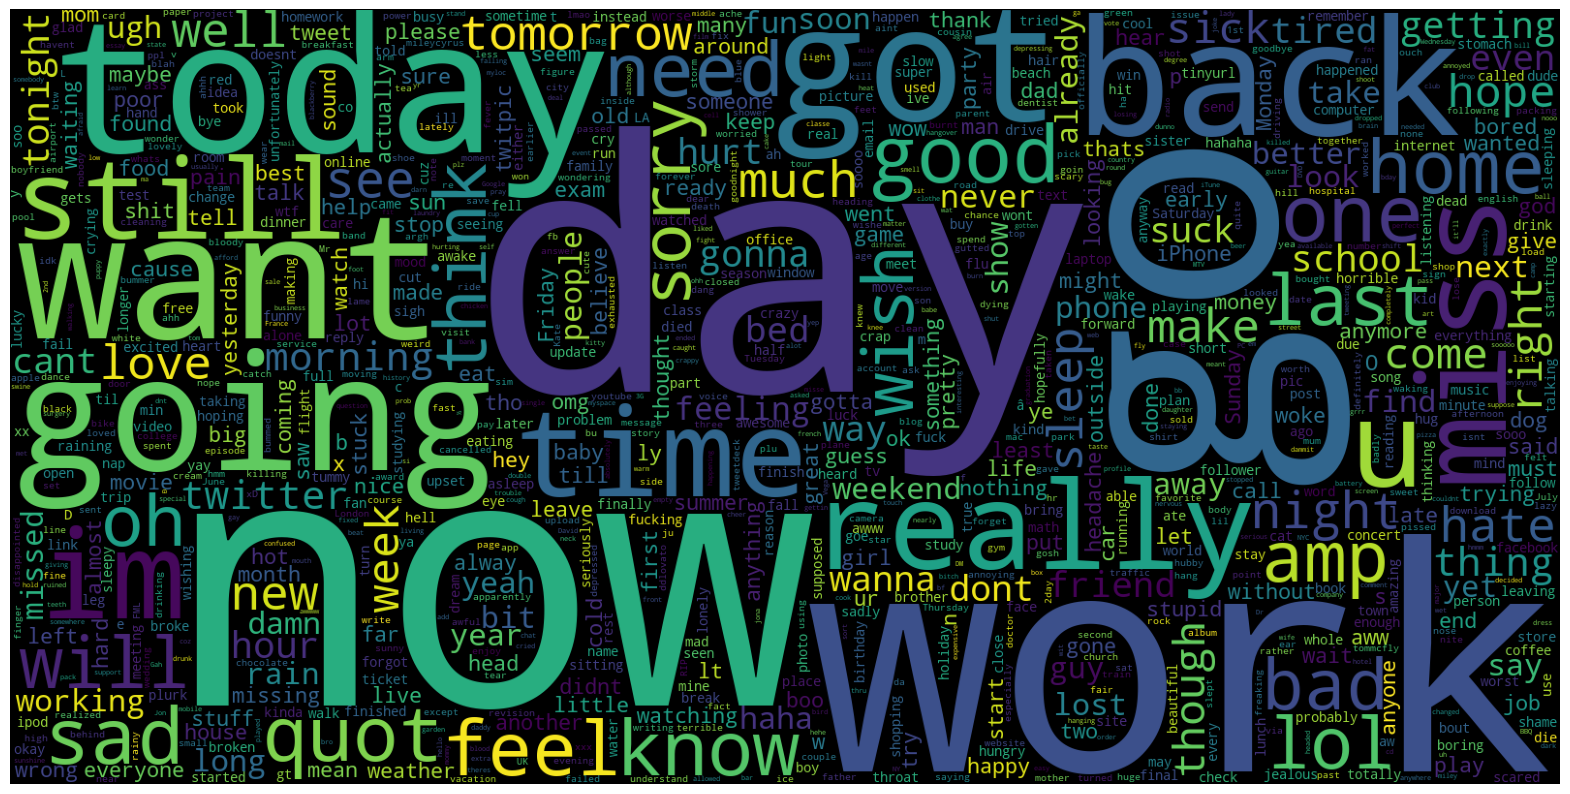

In [126]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data_neg = data['text'][:800000]

wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False)
wordcloud = wc.generate(" ".join(data_neg))
word_freq = wc.process_text(" ".join(data_neg))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_word_freq[:10]

for word, freq in top_words:
    print(f"{word}: {freq}")

plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


<h3>Положительные твиты</h3>

good: 62163
day: 55553
thank: 50347
love: 50329
quot: 45931
now: 41347
u: 39369
lol: 36207
time: 34326
going: 30932


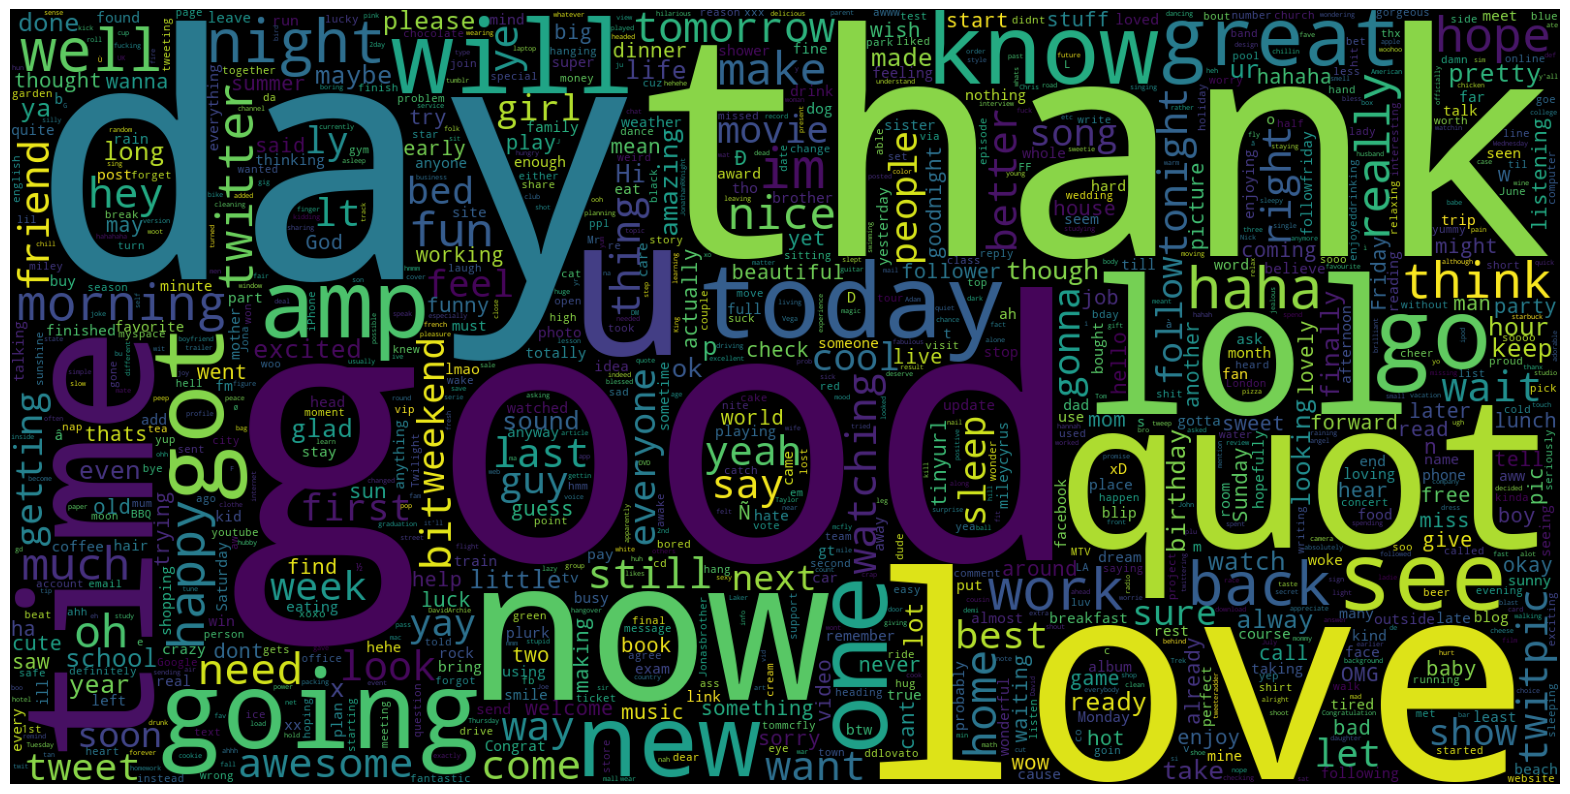

In [140]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data_pos = data['text'][800000:]

wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False)
wordcloud = wc.generate(" ".join(data_pos))
word_freq = wc.process_text(" ".join(data_pos))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_word_freq[:10]

for word, freq in top_words:
    print(f"{word}: {freq}")


plt.figure(figsize = (20,20))

plt.axis("off")
plt.imshow(wc)


<h1>Нейтральное облако слов</h1>

/var/folders/y8/ndh9qhzj7t98rv05wws177ph0000gn/T/ipykernel_21674/1064150081.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['text'].apply(get_sentiment)


day: 35247
now: 34570
go: 31382
work: 30323
back: 29257
going: 29232
quot: 28155
today: 26340
got: 25006
u: 24879


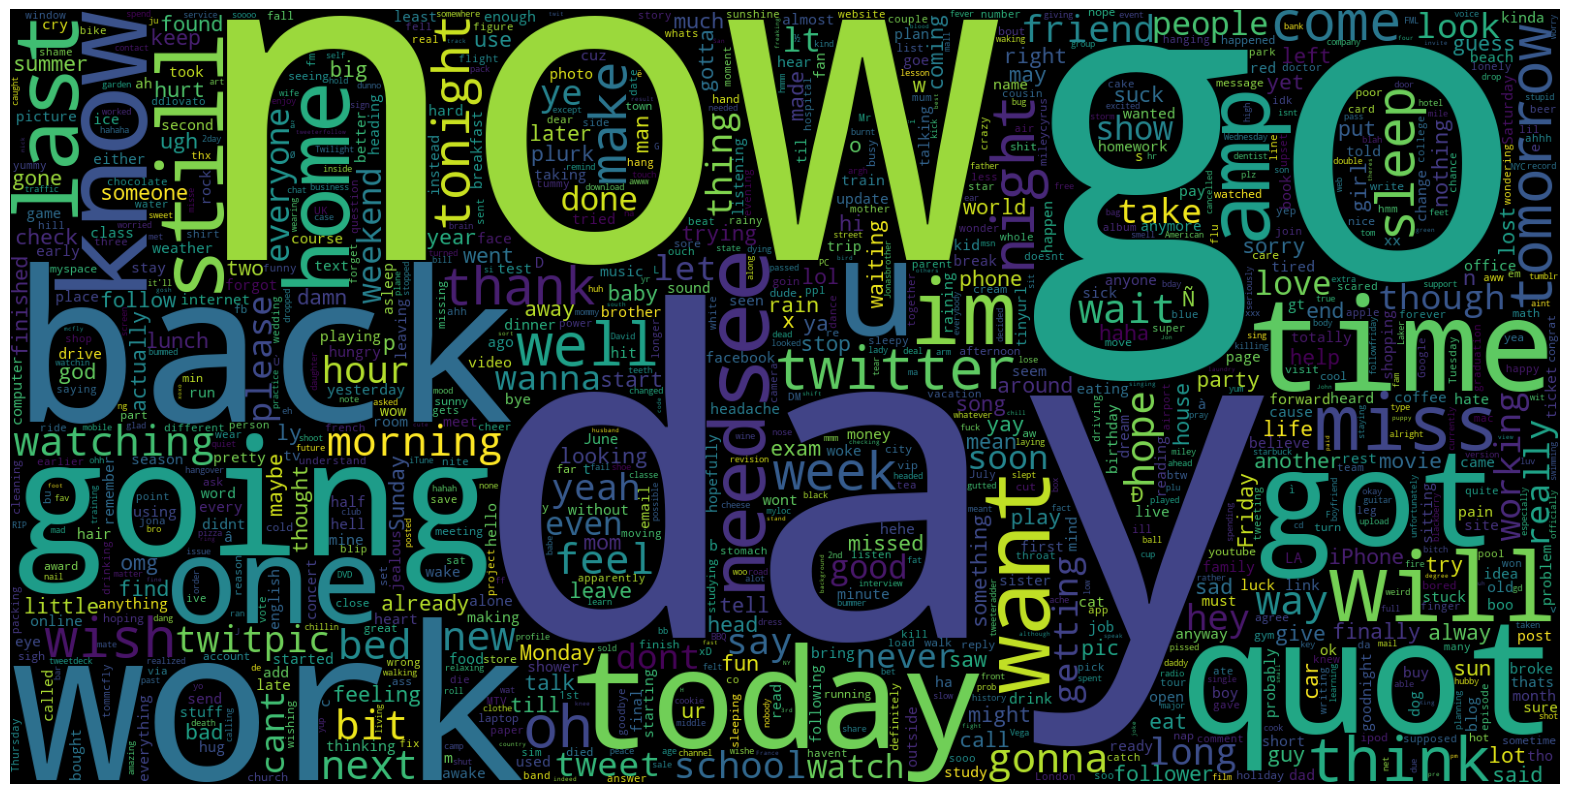

In [128]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob




def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity


data['sentiment'] = data['text'].apply(get_sentiment)


neutral_tweets = data[(data['sentiment'] > -0.1) & (data['sentiment'] < 0.1)]['text']

wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False)
wordcloud = wc.generate(" ".join(neutral_tweets))
word_freq = wc.process_text(" ".join(neutral_tweets))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_word_freq[:10]

for word, freq in top_words:
    print(f"{word}: {freq}")

plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


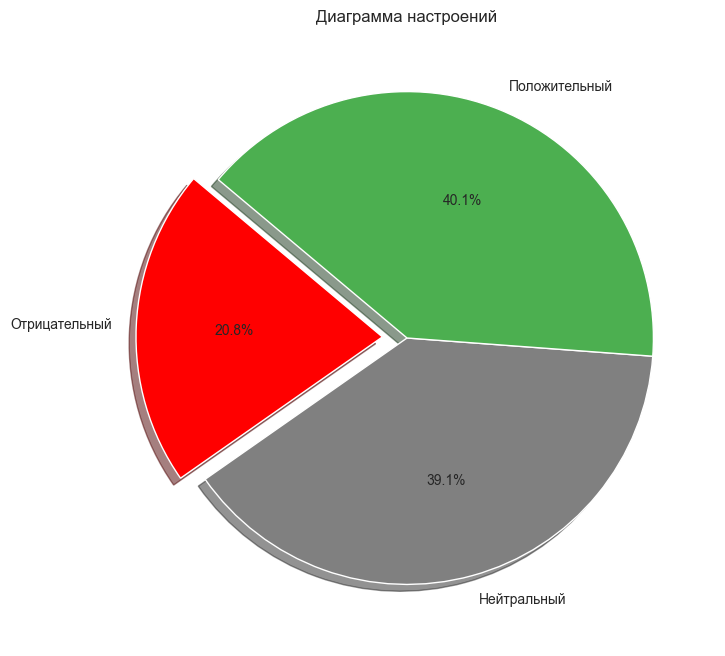

In [129]:
import matplotlib.pyplot as plt

# Предположим, у вас есть столбец 'sentiment' с оценками тональности в DataFrame

# Вычисление процента отрицательных, нейтральных и положительных твитов
negative_percentage = (data['sentiment'] < 0).mean() * 100
neutral_percentage = ((data['sentiment'] >= 0) & (data['sentiment'] < 0.1)).mean() * 100
positive_percentage = (data['sentiment'] >= 0.1).mean() * 100

# Данные для построения круговой диаграммы
labels = ['Отрицательный', 'Нейтральный', 'Положительный']
sizes = [negative_percentage, neutral_percentage, positive_percentage]
colors = ['red', 'gray', '#4CAF50']
explode = (0.1, 0, 0)  # Выделение сектора с отрицательными твитами

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Диаграмма настроений')
plt.show()


<h1>Разделеняем данных на обучающие и тестовые множества</h1>

In [130]:
# Разделяем 95% данных для обучения и 5% тестирования
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

<h1>Преобразовываем набор данных с помощью TF-IDF Vectorize</h1>

In [131]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('Количество признаковых слов: ', len(vectoriser.get_feature_names_out()))

Количество признаковых слов:  500000


In [132]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

<h3>После обучения модели мы применяем меры оценки, чтобы проверить, как работает модель. Соответственно, для проверки эффективности моделей мы используем следующие параметры оценки:
    <p>Оценка точности</p>
    <p>Confussion matrix с графиком</p>
    <p>Кривая ROC-AUC</h3></p>

In [133]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Прогнозируемые значения", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Актуальные значения" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix(Матрица ошибок)", fontdict = {'size':18}, pad = 20)


<h1>Построение модели</h1>
В постановке задачи мы использовали три различные модели, соответственно:

Наивный байесовский классификатор
SVM (машина опорных векторов)
Логистическая регрессия

Идея выбора этих моделей заключается в том, что мы хотим попробовать все классификаторы на наборе данных, начиная от простых и заканчивая сложными моделями, а затем попытаться найти ту, которая дает наилучшую производительность среди них.

<h1>Наивный байесовский классификатор</h1>

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



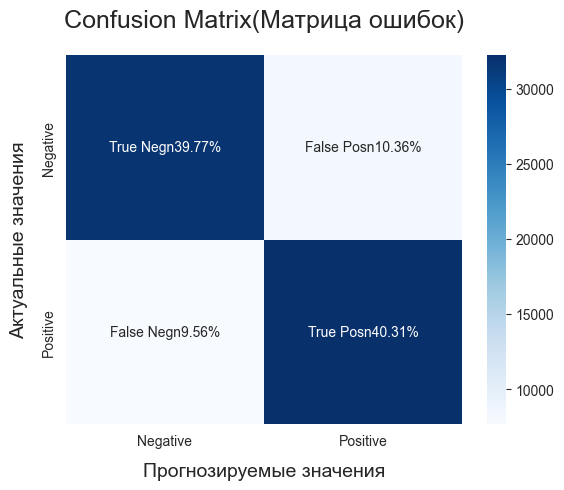

In [134]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

<h1>Кривая ROC-AUC для модели-1</h1>

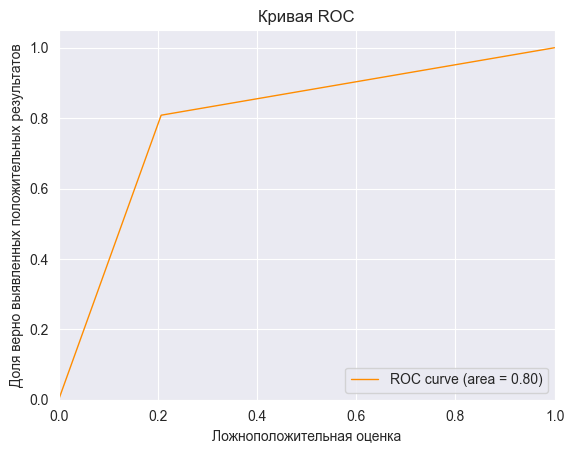

In [135]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная оценка')
plt.ylabel('Доля верно выявленных положительных результатов')
plt.title('Кривая ROC')
plt.legend(loc="lower right")
plt.show()

<h1>SVM(Машина опорных векторов)</h1>

/Users/ernazerkinbekov/Desktop/CourseProjectBigData/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



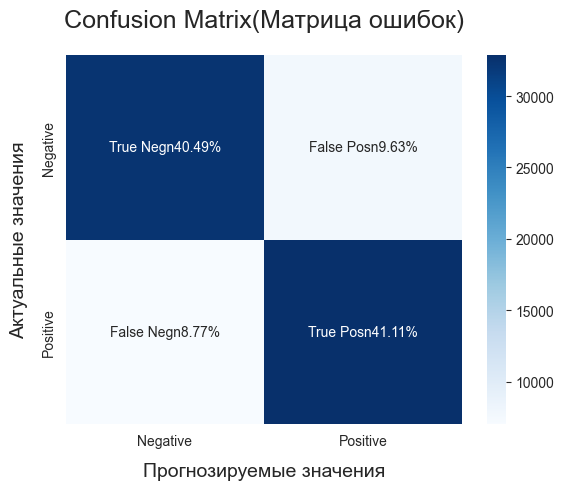

In [136]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

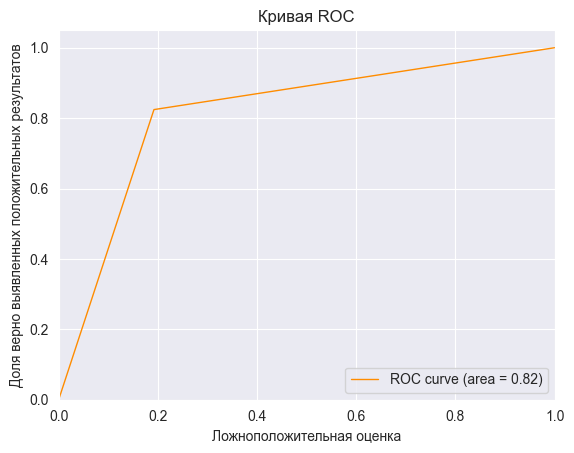

In [137]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная оценка')
plt.ylabel('Доля верно выявленных положительных результатов')
plt.title('Кривая ROC')
plt.legend(loc="lower right")
plt.show()

<h1>Логистическая регрессия</h1>

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



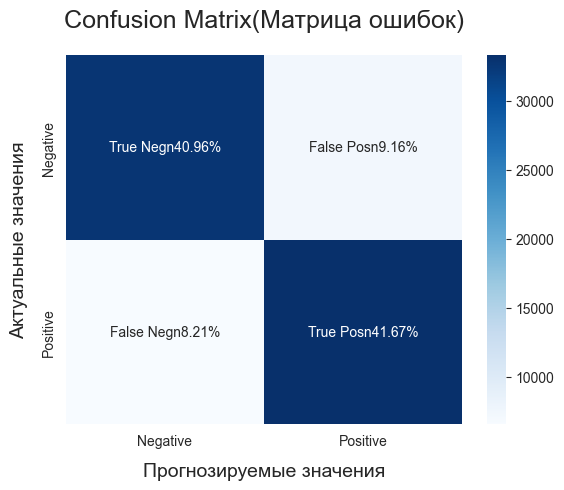

In [138]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

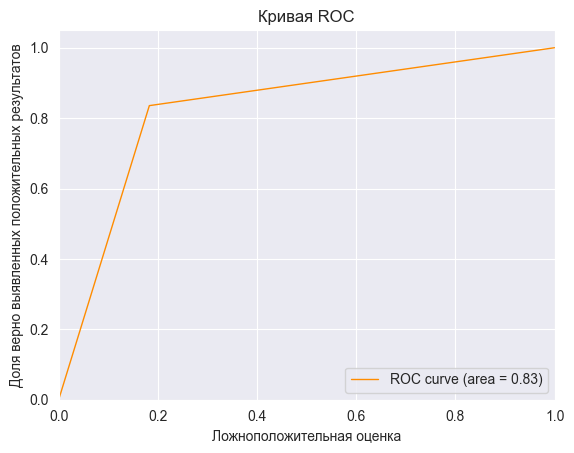

In [139]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная оценка')
plt.ylabel('Доля верно выявленных положительных результатов')
plt.title('Кривая ROC')
plt.legend(loc="lower right")
plt.show()

Оценив все модели, мы можем сделать следующие выводы, а именно.

Точность: По точности модели Logistic Regression превосходит SVM, которая, в свою очередь, превосходит Bernoulli Naive Bayes.

F1-score: Оценки F1 для класса 0 и класса 1 следующие:
(a) Для класса 0: Bernoulli Naive Bayes (точность = 0,80) < SVM (точность = 0,81) < Logistic Regression (точность = 0,83)
(b) Для класса 1: Bernoulli Naive Bayes (точность = 0.80) < SVM (точность = 0.82) < Логистическая регрессия (точность = 0.83)

Оценка AUC: Все три модели имеют почти одинаковый показатель ROC-AUC.

Таким образом, мы пришли к выводу, что логистическая регрессия является лучшей моделью для данного набора данных.

В нашей постановке задачи логистическая регрессия следует принципу бритвы Оккама, который определяет, что для конкретной постановки задачи, если данные не имеют предположений, лучше всего работает самая простая модель. Поскольку в нашем наборе данных нет никаких предположений, логистическая регрессия является простой моделью. Поэтому данная концепция справедлива для вышеупомянутого набора данных

Основные выводы

Анализ настроений в социальной сети Twitter используется для идентификации и классификации настроений, выраженных в текстовом источнике.
Логистическая регрессия, SVM и Naive Bayes - вот некоторые из алгоритмов ML, которые можно использовать для сентиментального анализа Twitter.